# SplitFed Model Optimization using Game Theoretic Approaches

In this notebook we aim to optimize SplitFed ([arXiv:2004.12088](https://arxiv.org/abs/2004.12088)), a combination of Split Learning ([arXiv:1810.06060](https://arxiv.org/abs/1810.06060), [arXiv:1812.00564](https://arxiv.org/abs/1812.00564)) and Federated Learning ([arXiv:1602.05629](https://arxiv.org/abs/1602.05629)), using game theoretic approaches. Specifically, we look at balancing the number of model layers trained on each client device with computation overhead, communication overhead, and inference performance.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413

In [2]:
from __future__ import annotations
import collections
import copy
import glob
import inspect
import itertools
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys
import tensorflow as tf
import tensorflow.keras as keras
import tqdm
from typing import Any, Callable, Iterable

In [3]:
sns.set() # Use seaborn themes.

## Environment Setup

This section contains code that is modifies output path locations, random seed, and logging.

In [4]:
# Set random seeds.
SEED = 0
tf.random.set_seed(SEED) # Only this works on ARC (since tensorflow==2.4).

In [5]:
# Setup logging (useful for ARC systems).
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG) # Must be lowest of all handlers listed below.
while logger.hasHandlers(): logger.removeHandler(logger.handlers[0]) # Clear all existing handlers.

# Custom log formatting.
formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')

# Log to STDOUT (uses default formatting).
sh = logging.StreamHandler(stream=sys.stdout)
sh.setLevel(logging.INFO)
logger.addHandler(sh)

# Set Tensorflow logging level.
tf.get_logger().setLevel('ERROR') # 'INFO'

In [6]:
# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
logger.info(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    logger.info(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


## Split Model Architecture

To do Split Learning, a base model must be divided into client/server sub-models for training and evaluation. There are several configuration approaches to doing this as described in [arXiv:1812.00564](https://arxiv.org/abs/1812.00564). In this implementation, we focus on the simpler _vanilla_ configuration, which leverages a single forward/backward propagation pipeline. That is, the client model has a single input and the server holds the data labels. In the forward pass, data propagates through the client model, the outputs of which are then passed to the server where the loss is computed. In the backward pass, the gradients are computed at the server then backpropagated through its model, the final gradients are then sent to the client, where the backpropagation continues until the client input layer.

In [36]:
def split_model(
    base_model: keras.models.Model,
    cut_layer_key: int|str,
    ) -> tuple[keras.models.Model, keras.models.Model]:

    # Extract client-side input/output layers from base model.
    inp_client = base_model.input
    if isinstance(cut_layer_key, int):
        out_client = base_model.get_layer(index=cut_layer_key).output
    else:
        out_client = base_model.get_layer(name=cut_layer_key).output

    # Build client model.
    model_client = keras.models.Model(inputs=inp_client, outputs=out_client)

    # Extract server-side input/output layers.
    inp_server = keras.layers.Input(tensor=out_client) # Convert client output tensor to input layer.
    out_server = base_model.output

    # Build server model.
    model_server = keras.models.Model(inputs=inp_server, outputs=out_server)

    # Return models.
    return model_server, model_client


def join_model(
    model_client: keras.models.Model,
    model_server: keras.models.Model,
    ) -> keras.models.Model:

    # Get input.
    inp = model_client.input
    x = inp

    # Generate graph from client (skip input).
    for layer in model_client.layers[1:]:
        x = layer(x)

    # Add server layers to graph (skip input).
    for layer in model_server.layers[1:]:
        x = layer(x)

    # Build the base model.
    model_base = keras.models.Model(inputs=inp, outputs=x)

    # Transfer client weights.
    for layer in model_client.layers[1:]:
        model_base.get_layer(name=layer.name).set_weights(layer.get_weights())

    # Transfer server weights.
    for layer in model_server.layers[1:]:
        model_base.get_layer(name=layer.name).set_weights(layer.get_weights())

    # Return the base model.
    return model_base




####### Example.
inp = keras.Input(shape=(10))
x = keras.layers.Dense(2, activation="relu", name="layer1")(inp)
x = keras.layers.Dense(3, activation="relu", name="layer2")(x)
x = keras.layers.Dense(4, activation="relu", name="layer3")(x)
x = keras.layers.Dense(5, name="output")(x)
model = keras.Model(inputs=inp, outputs=x)
s, c = split_model(model, 'layer2')

print("Base model:")
model.summary()

print("Client model:")
c.summary()

print("Server model:")
s.summary()

print("Rejoined model:")
base = join_model(c, s)
base.summary()

Base model:
Model: "model_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
layer1 (Dense)               (None, 2)                 22        
_________________________________________________________________
layer2 (Dense)               (None, 3)                 9         
_________________________________________________________________
layer3 (Dense)               (None, 4)                 16        
_________________________________________________________________
output (Dense)               (None, 5)                 25        
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________
Client model:
Model: "model_66"
_________________________________________________________________
Layer (type)      

## Federated Training Using Split Model

In [21]:
def split_train_step(
    model_server: keras.models.Model,
    model_client: keras.models.Model,
    x: tf.Tensor,
    y: tf.Tensor,
    ) -> dict[str, tf.Tensor]:
    """Split learning training step.

    Runs a single training step for the given server and client models.

    Note that the current implementation uses a single `tf.GradientTape` instance to
    reduce code complexity. This means that the current implementation is for simulation
    purposes only. True distributed learning would require a separate `tf.GradientTape`
    instance for each model, where the backpropagation is done using a Jacobian matrix
    across the separate tape gradients.

    Args:
        model_server (keras.models.Model): Server model (compiled with optimizer and loss).
        model_client (keras.models.Model): Client model (compiled with optimizer and loss).
        x (tf.Tensor): Batched training input.
        y (tf.Tensor): Batched training targets.

    Returns:
        dict[str, tf.Tensor]: Dictionary of server model metrics after the current training step.
    """

    # For this simulation we use a single GradientTape instance to make
    # the codebase simpler. A true distributed environment would require
    # a separate GradientTape instance for the server/client.
    with tf.GradientTape(persistent=True) as tape:

        ###### Client forward pass ######
        out_client = model_client(x, training=True)

        ###### Server forward pass ######
        out_server = model_server(out_client, training=True)

        ###### Server backward pass ######
        loss = model_server.compiled_loss(
            y_true=y,
            y_pred=out_server,
            regularization_losses=model_server.losses,
        )
        # Compute server gradients.
        grad_server = tape.gradient(loss, model_server.trainable_variables)
        # Update server weights.
        model_server.optimizer.apply_gradients(zip(grad_server, model_server.trainable_variables))
        # Update server metrics.
        model_server.compiled_metrics.update_state(
            y_true=y,
            y_pred=out_server,
        )

        ###### Client backward pass ######
        grad_client = tape.gradient(loss, model_client.trainable_variables)
        # Update local client weights.
        model_client.optimizer.apply_gradients(zip(grad_client, model_client.trainable_variables))
        # No need to update client metrics since lables are on the server.

    # Return dictionary of servermetrics (including loss).
    return {m.name: m.result() for m in model_server.metrics}


def split_test_step(
    model_server: keras.models.Model,
    model_client: keras.models.Model,
    x: tf.Tensor,
    y: tf.Tensor,
    ) -> dict[str, tf.Tensor]:
    """Split learning validation/test step.

    Runs a single validation/test step for the given server and client models.

    Args:
        model_server (keras.models.Model): Server model (compiled with optimizer and loss).
        model_client (keras.models.Model): Client model (compiled with optimizer and loss).
        x (tf.Tensor): Batched validation/test input.
        y (tf.Tensor): Batched validation/test targets.

    Returns:
        dict[str, tf.Tensor]: Dictionary of server model metrics after the current validation/test step.
    """

    ###### Client forward pass ######
    out_client = model_client(x, training=False)

    ###### Server forward pass ######
    out_server = model_server(out_client, training=False)
    # Update server metrics.
    model_server.compiled_metrics.update_state(
        y_true=y,
        y_pred=out_server,
    )

    # Return dictionary of servermetrics (including loss).
    return {f"val_{m.name}": m.result() for m in model_server.metrics}


def fed_avg(
    model_weights: dict[str, list[tf.Tensor]],
    dist: dict[str, float],
    ) -> list[tf.Tensor]:
    """Weighted average of model layer parameters.

    Args:
        model_weights (dict[str, list[tf.Tensor]]): Dictionary of model weight lists.
        dist (dict[str, float]): Distribution for weighted averaging.

    Returns:
        list[tf.Tensor]: List of averaged weight tensors for each layer of the model.
    """

    # Scale the weights using the given distribution.
    model_weights_scaled = [
        [dist[key] * layer for layer in weights] 
        for key, weights in model_weights.items()
    ]

    # Average the weights.
    avg_weights = []
    for weight_tup in zip(*model_weights_scaled):
        avg_weights.append(
            tf.math.reduce_sum(weight_tup, axis=0)
        )
    return avg_weights

# Inspired by: https://docs.python.org/3/library/itertools.html#itertools-recipes
def grouper(iterable: Iterable[Any], n: int, fillvalue: Any = None) -> Iterable[Any]:
    """Collects input into non-overlapping fixed-length chunks.

    Args:
        iterable (Iterable[Any]): Input sequence.
        n (int): Number of elements per chunk.
        fillvalue (Any, optional): Value to fill if last chunk has missing elements. Defaults to `None`.

    Returns:
        Iterable[Any]: Sequence of grouped elements.
    """
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

# Type alias the training history.
TrainHistory = dict[str, dict[str, list]]

###
# Vanilla SplitLearning configuration only.
###
def train_splitfed(
    model_server: keras.models.Model,
    model_client: keras.models.Model,
    model_builder_server: Callable[[keras.models.Model], keras.models.Model],
    model_builder_client: Callable[[keras.models.Model], keras.models.Model],
    client_data: dict[int|str, tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]], # Dictionary of client data, where values are tuple(train, val, test) subsets (assumes already batched). The length of the dictionary determines the number of clients.
    n_rounds: int, # Number of global communication rounds.
    n_epochs: int, # Number of local client training epochs.
    group_size: int, # Number of random clients within group.
    shuffle: bool = True, # Randomly select clients in a group.
    ) -> tuple[TrainHistory, tuple[keras.models.Model, keras.models.Model]]:
    # Determine number of clients.
    n_clients: int = len(client_data)
    # Maintain list of client IDs for grouping.
    client_ids = list(client_data)

    ########## Main Server ###############
    # Build initial server model.
    model_server = model_builder_server(model_server)

    # Copy of global server weight parameters.
    global_weights_server = copy.deepcopy(model_server.get_weights())
    ######################################

    ########## Federated Server ##########
    # Build initial client model.
    model_client = model_builder_client(model_client)

    # Copy of global client weight parameters.
    global_weights_client = copy.deepcopy(model_client.get_weights())
    #######################################

    # Track the training history.
    history: TrainHistory = {key: collections.defaultdict(list) for key in client_data}

    # Global training loop.
    # Communication rounds between server <--> clients.
    for round in range(n_rounds):

        # Shuffle the client IDs.
        if shuffle:
            np.random.shuffle(client_ids)

        # Generate groups of shuffled client IDs.
        groups = list(grouper(client_ids, n=group_size, fillvalue=None))
        n_groups = len(groups)
        for group, tup in enumerate(groups):
            # Preserve same initial server weights for each group.
            group_weights_server = copy.deepcopy(global_weights_server)

            # Perserve server weights for each client update.
            all_server_weights: dict[str, tf.Tensor] = {}

            # Train each client model.
            # This could be done in parallel, but here we do it 
            # synchronously for ease of development.
            all_client_weights: dict[str, tf.Tensor] = {}
            all_client_data_records_train: dict[str, int] = {}
            for client in filter(lambda value: value is not None, tup): # Remove any filled values.

                # Retreive data for current client.
                (train_dataset, val_dataset, test_dataset) = client_data[client]

                # Reset server model so that weights are fresh during synchronous updates.
                model_server.set_weights(group_weights_server)

                # Synchronize global client model to local client.
                model_client_local = model_builder_client(model_client)
                model_client_local.set_weights(global_weights_client)

                # Train the current model for the desired number of epochs.
                all_client_data_records_train[client] = 0 # Initialize record count.
                for epoch in range(n_epochs):

                    # Training loop.
                    with tqdm.tqdm(train_dataset, unit='batch') as pbar:
                        for step, (x_train_batch, y_train_batch) in enumerate(pbar):
                            pbar.set_description(f"[round {round+1}/{n_rounds}, group {group+1}/{n_groups}, client {client}, epoch {epoch+1}/{n_epochs}] train")

                            # Run a single training step.
                            metrics_train = split_train_step(
                                model_server=model_server,
                                model_client=model_client_local,
                                x=x_train_batch,
                                y=y_train_batch,
                            )

                            # Add current number of batches to total number of records for the current client.
                            all_client_data_records_train[client] += x_train_batch.shape[0]

                            # Update progress bar with metrics.
                            pbar.set_postfix({k:v.numpy() for k,v in metrics_train.items()})

                            # Add to history.
                            for k,v in metrics_train.items():
                                history[client][k].append(v.numpy())

                    # Validation loop.
                    with tqdm.tqdm(val_dataset, unit='batch') as pbar:
                        for x_val_batch, y_val_batch in pbar:
                            pbar.set_description(f"[round {round+1}/{n_rounds}, group {group+1}/{n_groups}, client {client}, epoch {epoch+1}/{n_epochs}] val")

                            # Run a single validation step.
                            metrics_val = split_test_step(
                                model_server=model_server,
                                model_client=model_client_local,
                                x=x_val_batch,
                                y=y_val_batch,
                            )

                            # Update progress bar with metrics.
                            pbar.set_postfix({k:v.numpy() for k,v in metrics_val.items()})

                            # Add to history.
                            for k,v in metrics_val.items():
                                history[client][k].append(v.numpy())

                    # Reset train/val metrics.
                    model_client.reset_metrics()
                    model_server.reset_metrics()

                # Create a copy of this client's model weights and preserve for future aggregation.
                all_client_weights[client] = copy.deepcopy(model_client_local.get_weights())

                # Create a copy of the server weights for the current group.
                group_weights_server = copy.deepcopy(model_server.get_weights())

                # Create a copy of the current server weights.
                all_server_weights[client] = copy.deepcopy(model_server.get_weights())

            # Count total number of data records across all clients.
            total_data_records = float(sum(v for _, v in all_client_data_records_train.items()))

            # Now perform federated averaging for weights of clients within the current group.
            # To do this, first compute distribution for weighted-average.
            # Then perform federated averaging weight aggregation.
            dist = {
                client: float(count)/total_data_records
                for client, count in all_client_data_records_train.items()
            }
            global_weights_client = fed_avg(model_weights=all_client_weights, dist=dist)

            # Also average server weights for each client update.
            global_weights_server = fed_avg(model_weights=all_server_weights, dist=dist)

    # Load the final global weights for the server and client.
    model_server.set_weights(global_weights_server)
    model_client.set_weights(global_weights_client)

    # Return server and client models.
    return history, (model_server, model_client)

## Game Theory Definitions

In [9]:
def compute_time_forward_prop(
    alpha: float, # Portion of network that client device `k` will train.
    W: float, # Total size of neural network to be trained.
    D_k: float, # Data size for client `k`.
    beta: float, # Amount of computational complexity of forward propagation.
    F_dk: float, # The computing resource of device `k`.
    ) -> float:
    """Computes `T_{d,k}^{F}`, the computing time for forward propagation of device `k`.

    Mathematically, this is:
        `T_{d,k}^{F} = (d * beta * W * D) / F_{d,k}`

    Args:
        alpha (float): Portion of network that client device `k` will train.
        W (float): Total size of neural network to be trained.
        D_k (float): Data size for client `k`.
        beta (float): Amount of computational complexity forward propagation.
        F_dk (float): The computing resource of device `k`, called `F_{d,k}`.

    Returns:
        float: `T_{d,k}^{F}`
    """
    return (alpha*beta*W*D_k)/F_dk

def compute_time_backward_prop(
    alpha: float, # Portion of network that client device `k` will train.
    W: float, # Total size of neural network to be trained.
    D_k: float, # Data size for client `k`.
    beta: float, # Amount of computational complexity of forward propagation.
    F_dk: float, # The computing resource of device `k`.
    ) -> float:
    """Computes `T_{d,k}^{B}`, the computing time for backward propagation of device `k`.

    Mathematically, this is:
        `T_{d,k}^{B} = (d * (1-beta) * W * D) / F_{d,k}`

    Args:
        alpha (float): Portion of network that client device `k` will train.
        W (float): Total size of neural network to be trained.
        D_k (float): Data size for client `k`.
        beta (float): Amount of computational complexity forward propagation.
        F_dk (float): The computing resource of device `k`, called `F_{d,k}`.

    Returns:
        float: `T_{d,k}^{B}`
    """
    return (alpha*(1-beta)*W*D_k)/F_dk

def compute_time_client(
    alpha: float, # Portion of network that client device `k` will train.
    W: float, # Total size of neural network to be trained.
    D_k: float, # Data size for client `k`.
    beta: float, # Amount of computational complexity of forward propagation.
    F_dk: float, # The computing resource of device `k`.
    ) -> float:
    """Computes `T_{d,k}`, the total computing time of device `k`.

    Mathematically, this is:
        `T_{d,k} = T_{d,k}^{F} + T_{d,k}^{B}`

    Args:
        alpha (float): Portion of network that client device `k` will train.
        W (float): Total size of neural network to be trained.
        D_k (float): Data size for client `k`.
        beta (float): Amount of computational complexity forward propagation.
        F_dk (float): The computing resource of device `k`, called `F_{d,k}`.

    Returns:
        float: `T_{d,k}`
    """
    T_F = compute_time_forward_prop(
        alpha=alpha,
        W=W,
        D_k=D_k,
        beta=beta,
        F_dk=F_dk,
    )
    T_B = compute_time_backward_prop(
        alpha=alpha,
        W=W,
        D_k=D_k,
        beta=beta,
        F_dk=F_dk,
    )
    return T_F + T_B

def compute_time_server(
    alpha: float, # Portion of network that client device `k` will train.
    W: float, # Total size of neural network to be trained.
    D_k: float, # Data size for client `k`.
    F_s: float, # The computing resource of the server.
    ) -> float:
    """Computes `T_{s}`, the computing time of the server `s` for a single client.

    Mathematically, this is:
        `T_{s} = ((1 - d) * W * D) / F_{s}`

    Args:
        alpha (float): Portion of network that the client device will train.
        W (float): Total size of neural network to be trained.
        D_k (float): Data size for client `k`.
        F_s (float): The computing resource of server `s`.

    Returns:
        float: `T_{s}`
    """
    return ((1-alpha)*W*D_k)/F_s

def compute_time_global_epoch(
    alpha: list[float], # Portion of network that client device `k` will train.
    W: float, # Total size of neural network to be trained.
    D_k: list[float], # Data size for each client `k`.
    beta: float, # Amount of computational complexity of forward propagation.
    F_dk: list[float], # The computing resource of each client `k`.
    F_s: float, # The computing resource of the server.
    return_parts: bool = False,
    ) -> float|tuple[float, float]:
    """Computes `T_{g}`, the total computing time of one global epoch with 1 server and a subset of `k` clients.

    Mathematically, this is:
        `T_{g} = \max_{k}{T_{d,k}^{F}} + \max_{k}{T_{d,k}^{B}} + \sum_{i=1}^{k}{T_{s}}`

    Args:
        alpha (list[float]): Portions of network that each client device `k` will train.
        W (float): Total size of neural network to be trained.
        D_k (list[float]): Data size.
        beta (float): Amount of computational complexity forward propagation.
        F_dk (list[float]): The computing resource of device `k`, called `F_{d,k}`.
        F_s (float): The computing resource of server `s`.
        return_parts (bool, optional): Flag to return tuple of components which comprise the final result. Defaults to `False`.

    Returns:
        float|tuple[float, float]: `T_{g}` or `(max_T_dk, sum_T_s)` where:
            - `max_T_dk = \max_{k}{T_{d,k}^{F}} + \max_{k}{T_{d,k}^{B}}`
            - `sum_T_s = \sum_{i=1}^{k}{T_{s}}`
    """
    # Convert to numpy arrays for vectorization.
    alpha = np.array(alpha)
    D_k = np.array(D_k)
    F_dk = np.array(F_dk)

    # Ensure all are same length.
    assert len(alpha) == len(D_k) == len(F_dk)

    # Compute maximum client compute time.
    max_T_dk = np.max(compute_time_client(
        alpha=alpha,
        W=W,
        D_k=D_k,
        beta=beta,
        F_dk=F_dk,
    ))

    # Compute total server compute time.
    sum_T_s = np.sum(compute_time_server(
        alpha=alpha,
        W=W,
        D_k=D_k,
        F_s=F_s,
    ))

    # Compute total time for one global epoch.
    if not return_parts:
        return max_T_dk + sum_T_s
    else:
        return max_T_dk, sum_T_s


# notes
# K - Large K is the size of the subset of clients that are chosen for federated averaging.
# Kappa - CPU parameter. Set this to be very small value (10^{-28}).
# F_dk - Set this to be actual CPU frequency of the client k.
# F_s - Set this to be actual CPU frequency of the server s.
# C - Set this value to be 1 (so we can ignore it).
# Beta - Set this value to be 1 (so we can ignore it).

def utility_client(
    alpha: float, # Portion of network that client device `k` will train.
    W: float, # Total size of neural network to be trained.
    D_k: float, # Data size for client `k`.
    F_dk: float, # The computing resource of device `k`.
    C_k: float, # Payoff of the server to the client device `k`.
    kappa: float, # CPU parameter. Set this to be very small value (10^{-28}).
    lam: float, # Discount factor.
    return_parts: bool = False,
    ) -> float|tuple[float, float, float]:
    """Computes `U_{d,k}`, the utility of client `k`.

    Mathematically, this is:
        `U_{d,k} = C_{k} * F_{d,k} - d * W * D * k * (F_{d,k}^2) + lam * \log_{2}{1 + d}`

    Args:
        alpha (float): Portion of network that client device `k` will train.
        W (float): Total size of neural network to be trained.
        D_k (float): Data size for client `k`.
        beta (float): Amount of computational complexity forward propagation.
        F_dk (float): The computing resource of device `k`, called `F_{d,k}`.
        C_k (float): Payoff of the server to the client device `k`.
        kappa (float): CPU parameter.
        lam (float): Privacy reward discount factor.
        return_parts (bool, optional): Flag to return tuple of components which comprise the final result. Defaults to `False`.

    Returns:
        float: `U_{d,k}` or `(reward_server, energy_consume_train, reward_privacy)` where:
            - `reward_server = C_{k} * F_{d,k}`
            - `energy_consume_train = d * W * D * kappa * (F_{d,k}^2)`
            - `reward_privacy = lam * \log_{2}{1 + d}`

    """
    reward_server = C_k * F_dk
    energy_consume_train = alpha * W * D_k * kappa * (F_dk**2.0)
    reward_privacy = lam * np.log2(1 + alpha)

    if not return_parts:
        return reward_server - energy_consume_train + reward_privacy
    else:
        return reward_server, energy_consume_train, reward_privacy

def utility_server(
    alpha: list[float], # Portion of network that client device `k` will train.
    W: float, # Total size of neural network to be trained.
    D_k: list[float], # Data size for each client `k`.
    beta: float, # Amount of computational complexity of forward propagation.
    F_dk: list[float], # The computing resource of each client `k`.
    F_s: float, # The computing resource of the server.
    K: float, # Total number of clients in selected subset.
    B: float, # Total budget.
    kappa: float, # CPU parameter. Set this to be very small value (10^{-28}).
    gamma: float, # Energy discount factor.
    rho: float, # Participating devices reward discount factor.
    return_parts: bool = False,
    ) -> float:
    """Computes `U_{s}`, the utility of the server given a subset of `k` clients.

    Args:
        alpha (list[float]): Portions of network that each client device `k` will train.
        W (float): Total size of neural network to be trained.
        D_k (list[float]): Data size for each client `k`.
        beta (float): Amount of computational complexity forward propagation.
        F_dk (list[float]): The computing resource of device `k`, called `F_{d,k}`.
        F_s (float): The computing resource of server `s`.
        K (float): Total number of clients in selected subset.
        B (float): Total budget.
        kappa (float): CPU parameter.
        gamma (float): Energy discount factor.
        rho (float): Participating devices reward discount factor.
        return_parts (bool, optional): Flag to return tuple of components which comprise the final result. Defaults to `False`.

    Returns:
        float: `U_{s}`
    """
    # # Convert to numpy arrays for vectorization.
    # d = np.array(d)
    # D_k = np.array(D_k)
    # F_dk = np.array(F_dk)

    # # Ensure all are same length.
    # assert len(d) == len(D_k) == len(F_dk)

    # Computing energy.
    energy_compute = gamma * (1-alpha) * K * W * D_k * kappa * (F_s**2.0)

    # Compute maximum client compute time.
    max_T_dk = np.max(compute_time_client(
        alpha=alpha,
        W=W,
        D_k=D_k,
        beta=beta,
        F_dk=F_dk,
    ))

    # Server time.
    time = (1-gamma)*((1-alpha)*(W*D_k*K)/F_s + max_T_dk)

    # Participation reward.
    reward_participation = rho*np.log2(1 + K)

    if not return_parts:
        return B - energy_compute - time + reward_participation
    else:
        return B, energy_compute, time, reward_participation

Here we define the optimization game algorithm, which optimizes the size of the network that a client `k` will train in the _SplitFed_ architecture. The algorithm is a combination of two sub-algorithms:

1. A bargaining process between the server $s$ and client devices $k$ (where $k \in [1, K]$) to find the optimal value of $d_{k}$.
2. A Stackelberg game based on the $d_{k}$ value found in part 1 above, which finds the optimal $(C, K, F_{d})$. To do this, it is formulated as 2 sub-games:
    1. The upper sub-game for the server (leader)
    2. The lower sub-game for the clients (followers)

/tmp/ipykernel_124154/933891410.py:139: RuntimeWarning: invalid value encountered in sqrt
  U_s = 8 + np.sqrt((18. - (U_k - 7)**2.)/2.) # Rearrange in terms of x2 = ...


(1000,) (1000,)


Text(0, 0.5, 'Server Utility ($U_{s}$)')

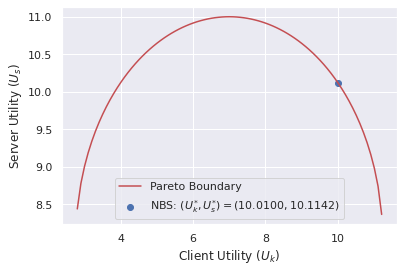

In [10]:
# Nash bargaining solution (NBS).
def game_nbs(
    *u: tuple[np.ndarray], # Utilities for variable number of players.
    d: list[float] = 0.,
    return_index: bool = False,
    ) -> tuple[float]|int:
    """Nash bargaining solution for variable number of players.

    Args:
        u (tuple[np.ndarray]): Utility values for each player. The number of elements in the tuple determine the number of players. Must be at least 2 players.
        d (list[float], optional): Disagreement value for each player. Defaults to `0.0`.
        return_index (bool, optional): Flag to return the index of the NBS within each utility vector. Defaults to `False`.

    Returns:
        tuple[float]|tuple[tuple[float],int]: Return value depends on the value of `return_index`.
            - `return_index=False`: Returns tuple of optimal utilities which satisfy the NBS.
            - `return_index=True`: Returns the index of the NBS within original utility vectors.
    """

    # Determine number of players.
    n = len(u)

    # Ensure all inputs are numpy arrays for vectorization.
    u = list(u)
    for i in range(n):
        u[i] = np.asarray(u[i])

    # Convert disagreement point to numpy array.
    d = np.asarray(d)

    # Allow 1 disagreement point to be duplicated for all players.
    if len(d) == 1:
        d = np.repeat(d, repeats=n)

    # Ensure disagreement point matches number of players.
    assert len(d) == n

    # Compute Nash product.
    nash_prod = np.prod(np.vstack(u).T - d, axis=1)

    # Find index of utilities which maximize the Nash product.
    # This is the index of the NBS.
    idx_nbs = np.nanargmax(nash_prod)

    # Return index of the NBS.
    if return_index:
        return idx_nbs
    # Return optimal utilities.
    else:
        return tuple([u[i][idx_nbs] for i in range(n)])


# Stackelberg game.
# Server is leader, clients are followers.
def game_stackelberg(
    *u: tuple[np.ndarray], # Utilities for variable number of players.
    idx_lead: int = 0,
    ):
    # Determine number of players.
    n = len(u)

    # Ensure all inputs are numpy arrays for vectorization.
    u = list(u)
    for i in range(n):
        u[i] = np.asarray(u[i])

    # Determine list of all follower indices.
    idx_follow = np.asarray(set(range(n)) - set(idx_lead))

    # 

# Entire game.
def game_optimize():
    pass










# W: float, # Total size of neural network to be trained.
# D_k: float, # Data size for client `k`.
# F_dk: float, # The computing resource of device `k`.
# K: float, # Total number of clients in selected subset.
# C_k: float, # Payoff of the server to the client device `k`.
# lam: float, # Discount factor.
# beta: float, # Amount of computational complexity of forward propagation.
# F_s: float, # The computing resource of the server.
# B: float, # Total budget.
# gamma: float, # Energy discount factor.
# rho: float, # Participating devices reward discount factor.


# d=np.arange(0.0, 5), # list[float], # Range of network portions that client device `k` will train.
# W=10.0, # float, # Total size of neural network to be trained.
# D_k=1.0, # float, # Data size for client `k`.
# F_dk=100.0, # float, # The computing resource of device `k`.
# K=1.0, # float, # Total number of clients in selected subset.
# C_k=100.0, # float, # Payoff of the server to the client device `k`.
# lam=0.5, # float, # Discount factor.
# beta=0.9, # float, # Amount of computational complexity of forward propagation.
# F_s=1.0, # float, # The computing resource of the server.
# B=1.0, # float, # Total budget.
# gamma=0.5, # float, # Energy discount factor.
# rho=0.5, # float, # Participating devices reward discount factor.
# # disagree=[-1000,1000]

# # Compute client utility for all `d` values.
# U_k = utility_client(
#     d=d,
#     W=W,
#     D_k=D_k,
#     F_dk=F_dk,
#     K=K,
#     C_k=C_k,
#     lam=lam,
# )

# # Compute the server utility for the current client.
# U_s = utility_server(
#     d=d,
#     W=W,
#     D_k=D_k,
#     beta=beta,
#     F_dk=F_dk,
#     F_s=F_s,
#     K=K,
#     B=B,
#     gamma=gamma,
#     rho=rho,
# )

alpha = np.linspace(0, 100, 1000)
U_k = alpha
U_s = 8 + np.sqrt((18. - (U_k - 7)**2.)/2.) # Rearrange in terms of x2 = ...



idx_nbs = game_nbs(
    U_k,
    U_s,
    d=[7,8],
    return_index=True,
)
U_k_star, U_s_star = U_k[idx_nbs], U_s[idx_nbs]
print(U_k.shape, U_s.shape)

plt.figure()
plt.plot(U_k, U_s, 'r-', label='Pareto Boundary')
plt.scatter(U_k_star, U_s_star, label=f'NBS: $(U_k^{{*}},U_s^{{*}}) = ({U_k_star:.4f},{U_s_star:.4f})$')
plt.legend()
plt.xlabel('Client Utility ($U_{k}$)')
plt.ylabel('Server Utility ($U_{s}$)')
# plt.xlim(left=0)

Text(0, 0.5, 'Server Utility ($U_{s}$)')

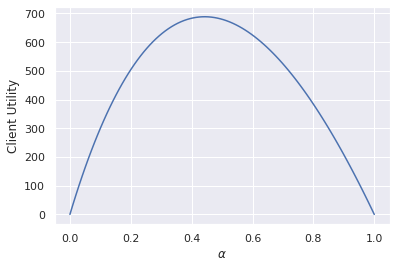

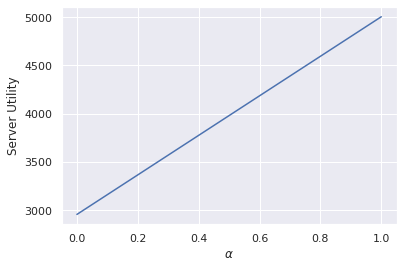

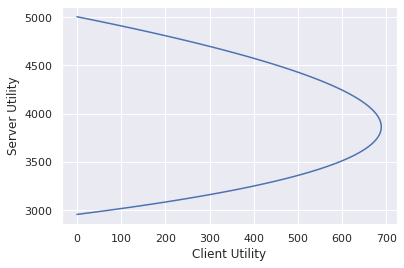

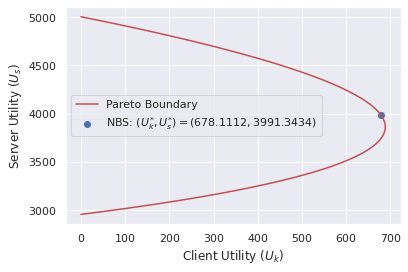

In [11]:
alpha = np.linspace(0, 1, 100)
# kappa = 1e-29
# F_s = F_dk = 2.4e9 # CPU speed of server and client (Hz).
# D_k = 10
# W = 1000

# Minsu's parameters.
F_s = 5e9 # CPU speed of server and client (Hz).
F_dk = 2e9
W = 1e6 #10^6; %this is w
D_k = 10e6 # 10x10^6; %this is D
B = 10e3 # 10*10^3; %this is B
kappa = 2e-28 # 2x10^(-28); %this is kappa
C_k = 1e-11 # 10^(-11); %this is c
lam = 8e3 # 8000; %this is lambda
gamma = 1e-3 # 0.001; %this is gamma, I just wanted to assume that the server prefers to minimize the training time
rho = 0.

U_k = utility_client(
    alpha=alpha, # Portion of network that client device `k` will train.
    W=W, # Total size of neural network to be trained.
    D_k=D_k, # Data size for client `k`.
    F_dk=F_dk, # The computing resource of device `k`.
    kappa=kappa, # Total number of clients in selected subset.
    C_k=C_k, # Payoff of the server to the client device `k`.
    lam=lam, # Discount factor.
    return_parts=False,
)

U_s = utility_server(
    alpha=alpha, # Portion of network that client device `k` will train.
    W=W, # Total size of neural network to be trained.
    D_k=D_k, # Data size for each client `k`.
    beta=1, # Amount of computational complexity of forward propagation.
    F_dk=F_dk, # The computing resource of each client `k`.
    F_s=F_s, # The computing resource of the server.
    K=1, # Total number of clients in selected subset.
    B=B, # Total budget.
    kappa=kappa, # CPU parameter. Set this to be very small value (10^{-28}).
    gamma=gamma, # Energy discount factor.
    rho=rho, # Participating devices reward discount factor.
    return_parts=False,
)

# U_s = np.linspace(8000, 5000, 100)


plt.figure()
plt.plot(alpha, U_k)
plt.xlabel('$\\alpha$')
plt.ylabel('Client Utility')

plt.figure()
plt.plot(alpha, U_s)
plt.xlabel('$\\alpha$')
plt.ylabel('Server Utility')

plt.figure()
plt.plot(U_k, U_s)
plt.xlabel('Client Utility')
plt.ylabel('Server Utility')


d = [0,0]

idx = U_k >= d[0]
U_k = U_k[idx]
U_s = U_s[idx]
idx = U_s >= d[1]
U_k = U_k[idx]
U_s = U_s[idx]

idx_nbs = game_nbs(
    U_k,
    U_s,
    d=d,
    return_index=True,
)

U_k_star, U_s_star = U_k[idx_nbs], U_s[idx_nbs]

plt.figure()
plt.plot(U_k, U_s, 'r-', label='Pareto Boundary')
plt.scatter(U_k_star, U_s_star, label=f'NBS: $(U_k^{{*}},U_s^{{*}}) = ({U_k_star:.4f},{U_s_star:.4f})$')
plt.legend()
plt.xlabel('Client Utility ($U_{k}$)')
plt.ylabel('Server Utility ($U_{s}$)')

## Experiments

In [12]:
def split_dataset(
    k: int, 
    x: np.ndarray,
    y: np.ndarray,
    shuffle: bool = False,
    ) -> list[tf.data.Dataset]:
    """Divides a dataset of X/Y tensors into `k` chunks.

    Args:
        k (int): Number of chunks.
        x (np.ndarray): X-value tensor.
        y (np.ndarray): Y-value tensor.
        shuffle (bool, optional): Shuffle the original indexes prior to chunking. Defaults to False.

    Returns:
        list[tf.data.Dataset]: List of chunked datasets.
    """
    n = x.shape[0] # Total number of records.
    chunk_size = int(np.ceil(float(n)/k)) # Number of records per chunk (round up).
    idx = np.arange(n) # List of original indices.

    # Shuffle original indices if desired.
    if shuffle:
        np.random.shuffle(idx)

    # Build datasets chunks.
    chunks: list[tf.data.Dataset] = []
    for i in range(k):
        s = slice(i*chunk_size, (i+1)*chunk_size)
        d = tf.data.Dataset.from_tensor_slices((x[idx[s]], y[idx[s]]))
        chunks.append(d)
    return chunks

### Simple MLP Classifier

Prepare MNIST 10-class data.

In [13]:
# Prepare the training dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Reserve 5,000 samples for validation, and 5,000 for testing.
x_test = x_train[-5000:]
y_test = y_train[-5000:]
x_val = x_train[-10000:-5000]
y_val = y_train[-10000:-5000]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Split the dataset into subsets for each client.
n_clients = 6
client_train = split_dataset(
    k=n_clients,
    x=x_train,
    y=y_train,
    shuffle=False,
)
client_val = split_dataset(
    k=n_clients,
    x=x_val,
    y=y_val,
    shuffle=False,
)
client_test = split_dataset(
    k=n_clients,
    x=x_test,
    y=y_test,
    shuffle=False,
)

# Build client data dictionary with batched datasets.
batch_size = 64
client_data = {
    i: (
        train_dataset.batch(batch_size=batch_size),
        val_dataset.batch(batch_size=batch_size),
        test_dataset.batch(batch_size=batch_size),
    )
    for i, (train_dataset, val_dataset, test_dataset) in enumerate(zip(client_train, client_val, client_test))
}

for i, (train_dataset, val_dataset, test_dataset) in client_data.items():
    print(f"client {i}: {tf.data.experimental.cardinality(train_dataset).numpy()=}")
    print(f"client {i}: {tf.data.experimental.cardinality(val_dataset).numpy()=}")
    print(f"client {i}: {tf.data.experimental.cardinality(test_dataset).numpy()=}")

client 0: tf.data.experimental.cardinality(train_dataset).numpy()=131
client 0: tf.data.experimental.cardinality(val_dataset).numpy()=14
client 0: tf.data.experimental.cardinality(test_dataset).numpy()=14
client 1: tf.data.experimental.cardinality(train_dataset).numpy()=131
client 1: tf.data.experimental.cardinality(val_dataset).numpy()=14
client 1: tf.data.experimental.cardinality(test_dataset).numpy()=14
client 2: tf.data.experimental.cardinality(train_dataset).numpy()=131
client 2: tf.data.experimental.cardinality(val_dataset).numpy()=14
client 2: tf.data.experimental.cardinality(test_dataset).numpy()=14
client 3: tf.data.experimental.cardinality(train_dataset).numpy()=131
client 3: tf.data.experimental.cardinality(val_dataset).numpy()=14
client 3: tf.data.experimental.cardinality(test_dataset).numpy()=14
client 4: tf.data.experimental.cardinality(train_dataset).numpy()=131
client 4: tf.data.experimental.cardinality(val_dataset).numpy()=14
client 4: tf.data.experimental.cardinality(

Define the model.

In [14]:
def compile_model(model: keras.models.Model):
    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['acc'],
        )
    return model

def build_model(n_class: int, input_shape: tuple, layers: list[int]):
    inputs = keras.Input(shape=input_shape, name="input")
    x = inputs
    for i, units in enumerate(layers):
        x = keras.layers.Dense(units, activation="relu", name=f'dense{i}')(x)
    outputs = keras.layers.Dense(n_class, name="classifier")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

Build and train the model.

[round 1/4, group 1/1, client 0, epoch 1/1] train: 100%|██████████| 131/131 [00:01<00:00, 91.00batch/s, loss=3.64, acc=0.617]
[round 1/4, group 1/1, client 0, epoch 1/1] val: 100%|██████████| 14/14 [00:00<00:00, 289.55batch/s, val_loss=3.64, val_acc=0.629]
[round 1/4, group 1/1, client 1, epoch 1/1] train: 100%|██████████| 131/131 [00:01<00:00, 92.18batch/s, loss=2.22, acc=0.662]
[round 1/4, group 1/1, client 1, epoch 1/1] val: 100%|██████████| 14/14 [00:00<00:00, 295.15batch/s, val_loss=2.22, val_acc=0.677]
[round 1/4, group 1/1, client 2, epoch 1/1] train: 100%|██████████| 131/131 [00:01<00:00, 91.83batch/s, loss=1.6, acc=0.7]   
[round 1/4, group 1/1, client 2, epoch 1/1] val: 100%|██████████| 14/14 [00:00<00:00, 288.44batch/s, val_loss=1.6, val_acc=0.71]
[round 1/4, group 1/1, client 3, epoch 1/1] train: 100%|██████████| 131/131 [00:01<00:00, 91.33batch/s, loss=1.36, acc=0.706]
[round 1/4, group 1/1, client 3, epoch 1/1] val: 100%|██████████| 14/14 [00:00<00:00, 290.67batch/s, val_

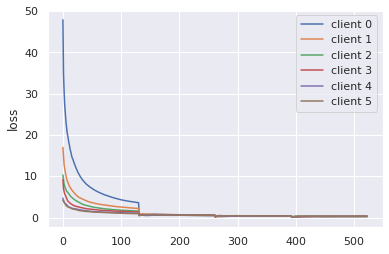

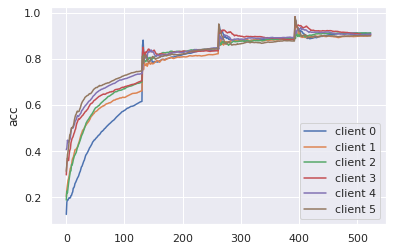

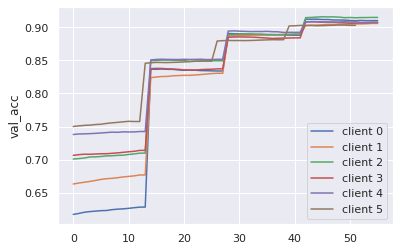

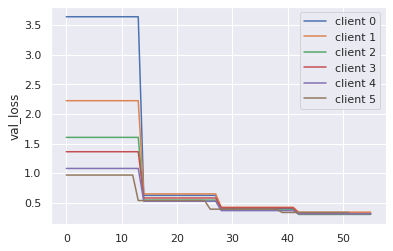

In [22]:
# Build the model.
model = build_model(
    n_class=10,
    input_shape=(784,),
    layers=[64, 64, 64, 64],
)
server, client = split_model(model, 'dense1')

# Train the model using SFL.
history, (server_trained, client_trained) = train_splitfed(
    model_server=server,
    model_client=client,
    model_builder_server=compile_model,
    model_builder_client=compile_model,
    client_data=client_data, # Dictionary of client data, where values are tuple(train, val, test) subsets (assumes already batched). The length of the dictionary determines the number of clients.
    n_rounds=4, # Number of global communication rounds.
    n_epochs=1, # Number of local client training epochs.
    group_size=n_clients,
    shuffle=False,
)


# Plot the metrics.
metric_keys = list(set([k for _, hdict in history.items() for k in hdict]))
fig_ax = {key: plt.subplots() for key in metric_keys}
for client, hdict in history.items():
    for key, vals in hdict.items():
        fig, ax = fig_ax[key]
        ax.plot(vals, label=f"client {client}")
        ax.set_xlabel('step')
        ax.set_ylabel(key)
        ax.legend()

# # Print model summaries.
# client.summary()
# server.summary()

Compare split performance against single model performance.

Epoch 1/4
782/782 [==============================] - 4s 5ms/step - loss: 2.5776 - acc: 0.6914 - val_loss: 0.3923 - val_acc: 0.8878
Epoch 2/4
782/782 [==============================] - 1s 1ms/step - loss: 0.2931 - acc: 0.9161 - val_loss: 0.2600 - val_acc: 0.9288
Epoch 3/4
782/782 [==============================] - 1s 1ms/step - loss: 0.1947 - acc: 0.9439 - val_loss: 0.2375 - val_acc: 0.9374
Epoch 4/4
782/782 [==============================] - 1s 1ms/step - loss: 0.1681 - acc: 0.9508 - val_loss: 0.2158 - val_acc: 0.9460


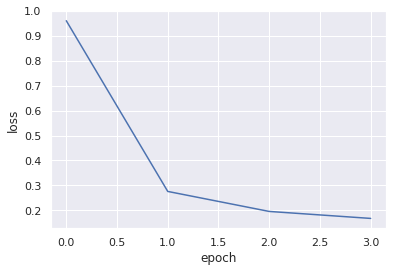

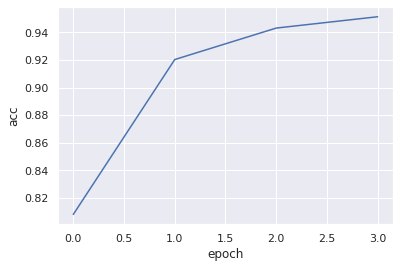

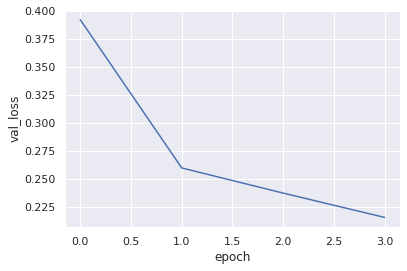

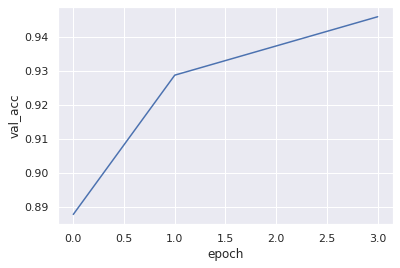

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size=batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size=batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size=batch_size)

model = build_model(
    n_class=10,
    input_shape=(784,),
    layers=[64, 64, 64, 64],
)
model = compile_model(model)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=4)

for key, values in history.history.items():
    plt.figure()
    plt.plot(values)
    plt.ylabel(key)
    plt.xlabel('epoch')